# Kickstarter Data Analysis

# Libraries Required

In [1]:
#Importing libraries for analysis
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import numpy as np
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from sklearn import preprocessing

# Import Dataset

## First loading in the dataframe and convert columns to desired data types. 
Dropping the columns ID, goal, pledged, and usd pledged since they are not needed.

Adding two columns: duration(days) and launch_year to look at projects over their funding time frame as well as trends over the years.

In [2]:
dataframe = pd.read_csv('ks-projects-201801.csv')
dataframe['deadline'] = pd.to_datetime(dataframe['deadline'])
dataframe['launched'] = pd.to_datetime(dataframe['launched'])
dataframe['launched'] = dataframe['launched'].astype('datetime64[D]')
ks = dataframe.drop(['ID','goal', 'pledged', 'usd pledged'], 1)
ks['duration(days)'] = (ks['deadline'] - ks['launched']).dt.days
ks['launch_year'] = ks['launched'].dt.year
ks.head(5)

,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,duration(days),launch_year
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11,failed,0,GB,0.0,1533.95,59,2015
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02,failed,15,US,2421.0,30000.00,60,2017
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12,failed,3,US,220.0,45000.00,45,2013
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17,failed,1,US,1.0,5000.00,30,2012
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,2015-07-04,canceled,14,US,1283.0,19500.00,56,2015


# Data Cleansing

In [3]:
#Showing the values of the state column
print(ks['state'].value_counts().index)

Index(['failed', 'successful', 'canceled', 'undefined', 'live', 'suspended'], dtype='object')


## Since I'm looking at successful and failed projects, want to get rid of projects that are live, cancelled, suspended, and undefined. 

In [4]:
#Filtering the dataset to look only at successful and failed projects
ks = ks[(ks['state'] == 'successful') | (ks['state'] == 'failed')]
ks.head(5)

,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,duration(days),launch_year
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11,failed,0,GB,0.0,1533.95,59,2015
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02,failed,15,US,2421.0,30000.00,60,2017
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12,failed,3,US,220.0,45000.00,45,2013
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17,failed,1,US,1.0,5000.00,30,2012
5,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,2016-02-26,successful,224,US,52375.0,50000.00,35,2016


## Keeping only the successful and failed projects filters the data down to 331675 entries out of 378660.

In [5]:
#Printing some basic info and descriptive statistics
ks.info()
ks.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   name              331672 non-null  object        
 1   category          331675 non-null  object        
 2   main_category     331675 non-null  object        
 3   currency          331675 non-null  object        
 4   deadline          331675 non-null  datetime64[ns]
 5   launched          331675 non-null  datetime64[ns]
 6   state             331675 non-null  object        
 7   backers           331675 non-null  int64         
 8   country           331675 non-null  object        
 9   usd_pledged_real  331675 non-null  float64       
 10  usd_goal_real     331675 non-null  float64       
 11  duration(days)    331675 non-null  int64         
 12  launch_year       331675 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(3), object(6)
memor

,backers,usd_pledged_real,usd_goal_real,duration(days),launch_year
count,331675.000000,3.316750e+05,3.316750e+05,331675.000000,331675.000000
mean,116.381581,9.943461e+03,4.151000e+04,33.954875,2014.180002
std,965.427268,9.673293e+04,1.108930e+06,12.713332,1.930922
min,0.000000,0.000000e+00,1.000000e-02,1.000000,2009.000000
25%,2.000000,5.000000e+01,2.000000e+03,30.000000,2013.000000
50%,15.000000,7.880000e+02,5.000000e+03,30.000000,2014.000000
75%,63.000000,4.608000e+03,1.500000e+04,36.000000,2016.000000
max,219382.000000,2.033899e+07,1.663614e+08,92.000000,2017.000000


In [6]:
#Filtering the categorical columns and showing the unique values in each column
filt_cat = ['category', 'main_category', 'currency', 'state', 'country']
df_filt = ks[filt_cat].columns
for col in df_filt:
    print(str(col).upper())
    print(ks[col].unique())
    print('')

CATEGORY
['Poetry' 'Narrative Film' 'Music' 'Restaurants' 'Food' 'Drinks'
 'Nonfiction' 'Indie Rock' 'Crafts' 'Games' 'Tabletop Games' 'Design'
 'Comic Books' 'Art Books' 'Fashion' 'Childrenswear' 'Theater' 'Comics'
 'DIY' 'Webseries' 'Animation' 'Food Trucks' 'Product Design' 'Public Art'
 'Documentary' 'Illustration' 'Photography' 'Pop' 'People' 'Art' 'Family'
 'Fiction' 'Film & Video' 'Accessories' 'Rock' 'Hardware' 'Software'
 'Weaving' 'Web' 'Jazz' 'Ready-to-wear' 'Festivals' 'Video Games'
 'Anthologies' 'Publishing' 'Shorts' 'Gadgets' 'Electronic Music'
 'Radio & Podcasts' 'Cookbooks' 'Apparel' 'Metal' 'Comedy' 'Hip-Hop'
 'Periodicals' 'Dance' 'Technology' 'Painting' 'World Music' 'Photobooks'
 'Drama' 'Architecture' 'Young Adult' 'Latin' 'Mobile Games' 'Flight'
 'Fine Art' 'Action' 'Playing Cards' 'Makerspaces' 'Punk'
 "Children's Books" 'Apps' 'Audio' 'Performance Art' 'Ceramics' 'Vegan'
 'Graphic Novels' 'Fabrication Tools' 'Performances' 'Sculpture' 'Sound'
 'Stationery' 'Pri

In [7]:
#Showing the values of the launch years to see if any incorrect data
print(ks['launch_year'].unique())

[2015 2017 2013 2012 2016 2014 2010 2011 2009]


# Issues to Explore:
* What categories/main categories are more successful/profitable?
* How do projects fare over the years?
* Does the number of backers help a product have more pledged/more success?
* What are characteristics of a successful project?
* How much do successful projects overshoot their goal?
* What, if anything, correlates with a successful project?

## Looking at barplots of the categorical columns, we see that there are more failed than successful projects. Also, with the vast majority of projects being from the US and using USD as currency, Kickstarter doesn't seem to be as popular or as known in other countries.

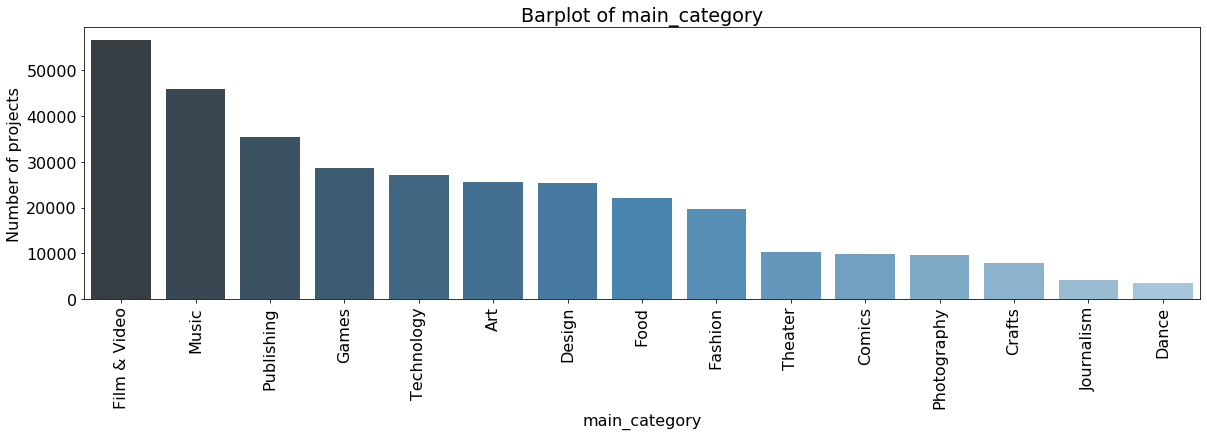

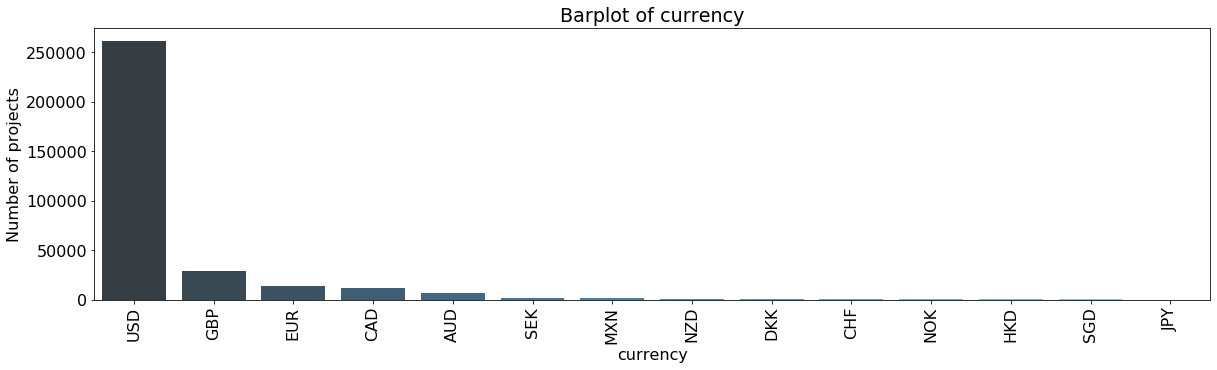

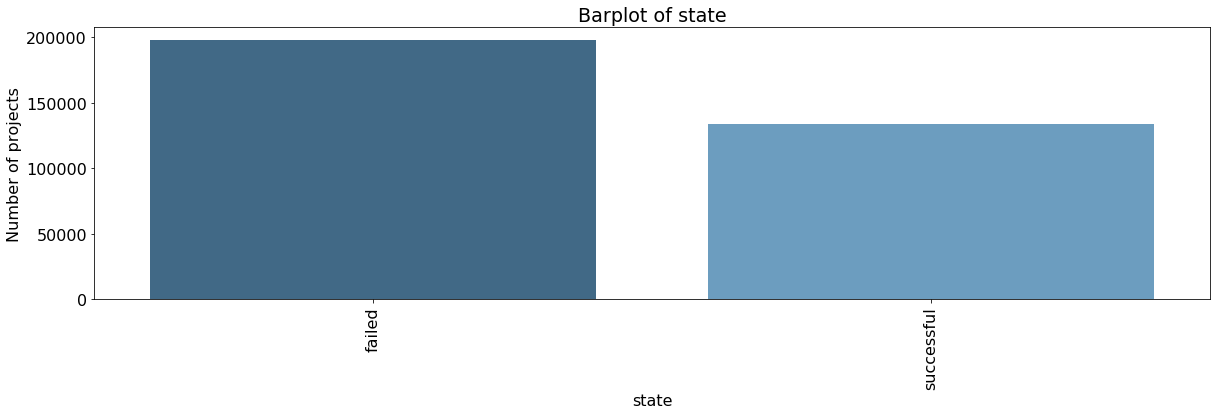

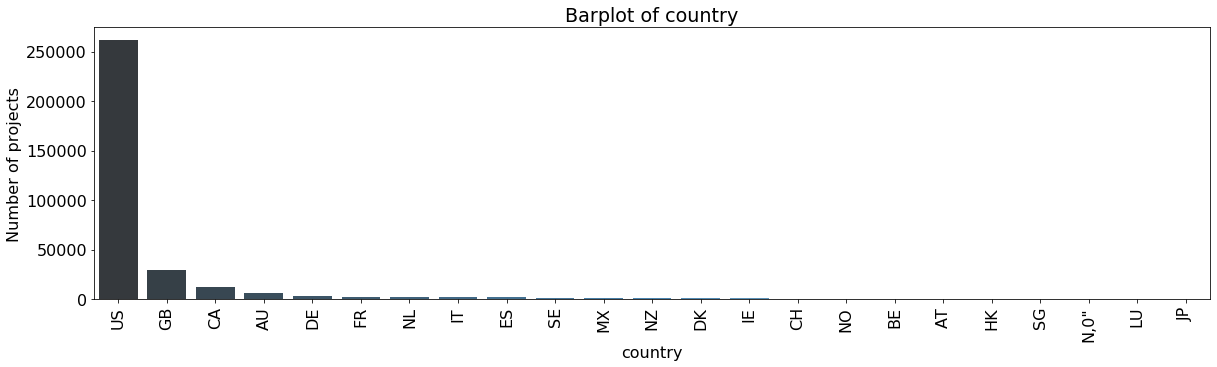

In [8]:
#Setting the figure and font size
plt.rcParams['figure.figsize'] = (20,5)
plt.rcParams['font.size'] = 16

#Creating a filter for the categorical columns
filt_cat = ['main_category', 'currency', 'state', 'country']
df_filt = ks[filt_cat].columns
#Looping through the filter to show a barplot of project counts in each filtered column
for col in df_filt:
    counts = ks[col].value_counts()
    fig, ax = plt.subplots()
    _ = sns.barplot(counts.index, counts, palette='Blues_d')
    _ = ax.set_xlabel(col)
    _ = plt.xticks(rotation=90)
    _ = ax.set_ylabel('Number of projects')
    _ = plt.title('Barplot of ' + str(col))

## Looking at some basic plots, we see the number of projects in each category.
Filtered to top 20 since there are way too many categories to show them all. Comparing the top category of Product Design to the rest of the top 20, we see almost double the projects than most of the other categories. With so many projects in Product Design, it may be difficult to bring a new one into funding to become successful.

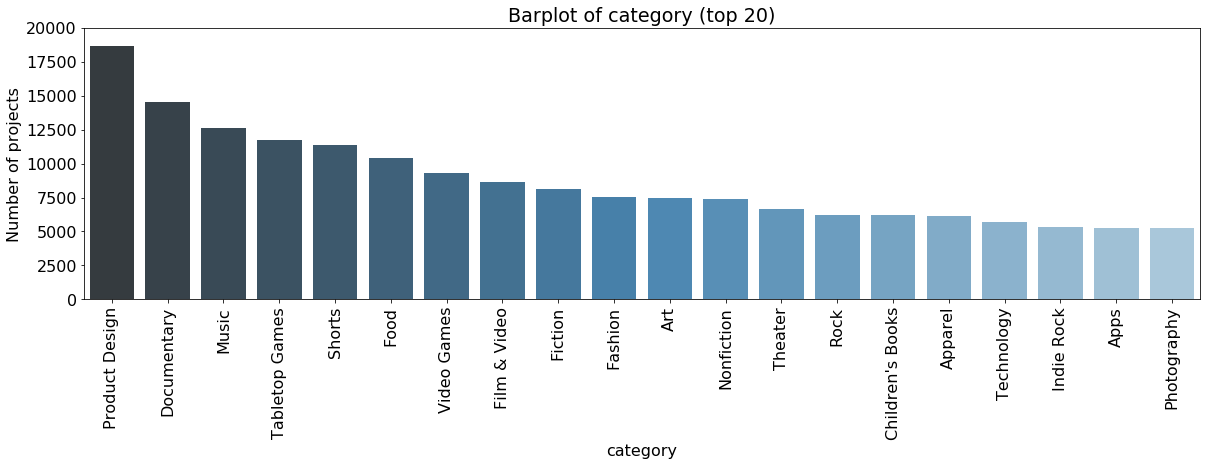

In [9]:
#Setting the figure and font size
plt.figure(figsize=(20,5))
plt.rcParams['font.size'] = 16

#Finding the counts of each category and plotting in a bar plot (limiting to top 20 since there are 159)
counts = ks['category'].value_counts()
_ = sns.barplot(counts.index[:20], counts[:20], palette='Blues_d')
_ = plt.xlabel('category')
_ = plt.xticks(rotation=90)
_ = plt.yticks(range(0,22500,2500))
_ = plt.ylabel('Number of projects')
_ = plt.title('Barplot of category (top 20)')

In [10]:
#Create a funciton to remove outliers from an input and return the input without outliers
def remove_outliers(data):
    
    #Finding the upper and lower quartiles as well as the IQR
    Q1 = np.percentile(data, 25, axis=0)
    Q3 = np.percentile(data, 75, axis=0)
    IQR = Q3 - Q1
    
    #Finding the upper and lower limits for outliers and removing them
    upper = Q3 + 1.5*IQR
    lower = Q1 - 1.5*IQR
    return data[~((data < lower)|(data > upper))]

## What does the project duration look like? 
Checking outliers of the number of days between launched and the deadline to find the average duration, which ends up being 31.5 days after removing outliers (33.95 days with outliers). We see a median duration of 30 days, so we see a right skew of the duration. With the average duration being greater than the median, and the majority of the funding durations being around 30 days, extending the funding time may not help in reaching goal amounts. 

Average duration with outliers is 33.95 days.
Average duration with no outliers is 31.5 days.
Median duration is 30.0 days.


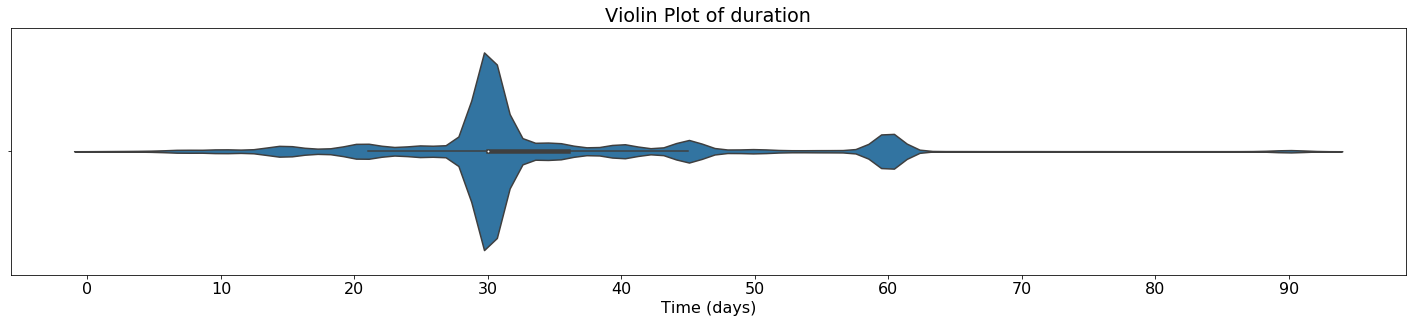

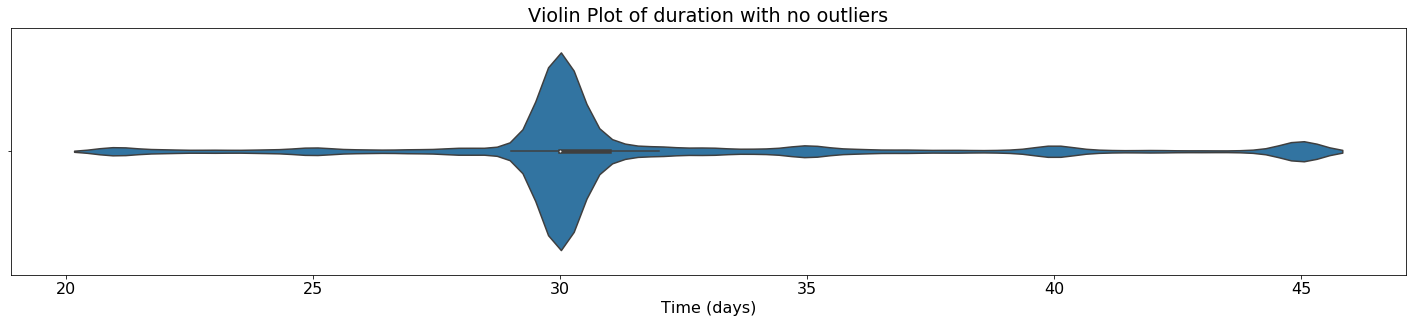

In [11]:
duration = ks['duration(days)']
duration_no_outliers = remove_outliers(duration)

#Plotting the duration with and without outliers
plt.figure(figsize=(25,10))
plt.subplot(2,1,1)
_ = sns.violinplot(duration)
_ = plt.xlabel('Time (days)')
_ = plt.xticks(range(0,100,10))
_ = plt.title('Violin Plot of duration')
plt.figure(figsize=(25,10))
plt.subplot(2,1,2)
_ = sns.violinplot(duration_no_outliers)
_ = plt.xlabel('Time (days)')
_ = plt.title('Violin Plot of duration with no outliers')

print('Average duration with outliers is ' + str(round(np.mean(duration),2)) + ' days.')
print('Average duration with no outliers is ' + str(round(np.mean(duration_no_outliers),2)) + ' days.')
print('Median duration is ' + str(np.median(duration)) + ' days.')

## How are the number of projects progressing over the years? 
Increasing project numbers over the years since Kickstarter launched in 2009 is a good sign, however we see a downtick in the number of projects after 2015. Kickstarter may have had stricter requirements for projects, or potentially have noticed fake projects being put up by bots and purged those. The continuing downtrend of project numbers from 2015-2017 though could be from a decrease in popularity of Kickstarter or a rise in competition from other funding websites/sources.

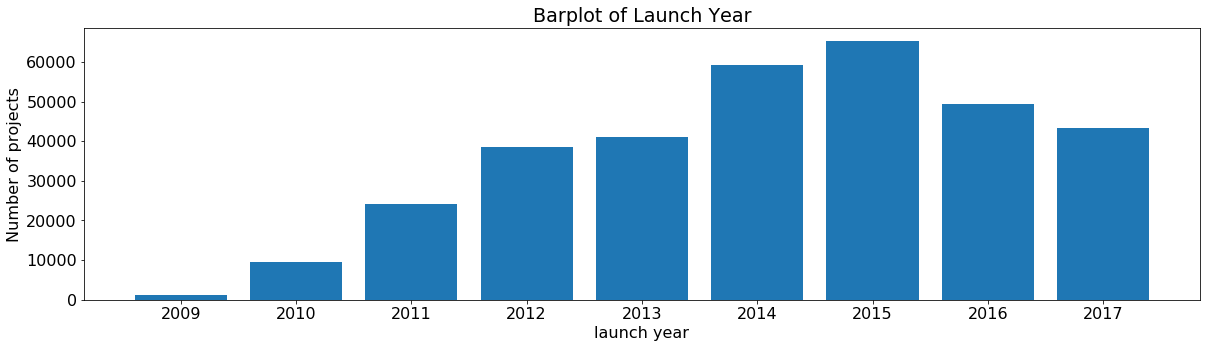

In [12]:
#Plotting number of projects over the years
counts = ks['launch_year'].value_counts()
_ = plt.bar(counts.index, counts)
_ = plt.xlabel('launch year')
_ = plt.xticks(range(2009,2018))
_ = plt.ylabel('Number of projects')
_ = plt.title('Barplot of Launch Year')

## Next we want to look at the differences between successful and failed projects.

We have a definite skew in the data, noticing the difference between the mean and the median values in each column.

Looking at success vs failed projects, we see more backers and more pledged for successful projects which isn't surprising. We also see lower median goal and a lower median duration of projects for successful projects. We could have a potential relationship between duration and success, as well as goal and success. We'll have to explore to see if this relationship is a negative correlation. 

In [13]:
#Filtering the dataset into success/failure sets to analyze each individually
ks_success = ks[ks['state'] == 'successful']
ks_fail = ks[ks['state'] == 'failed']

#Creating a filter for numerical data and showing success description
filt_num = ['backers', 'usd_goal_real', 'usd_pledged_real', 'duration(days)']

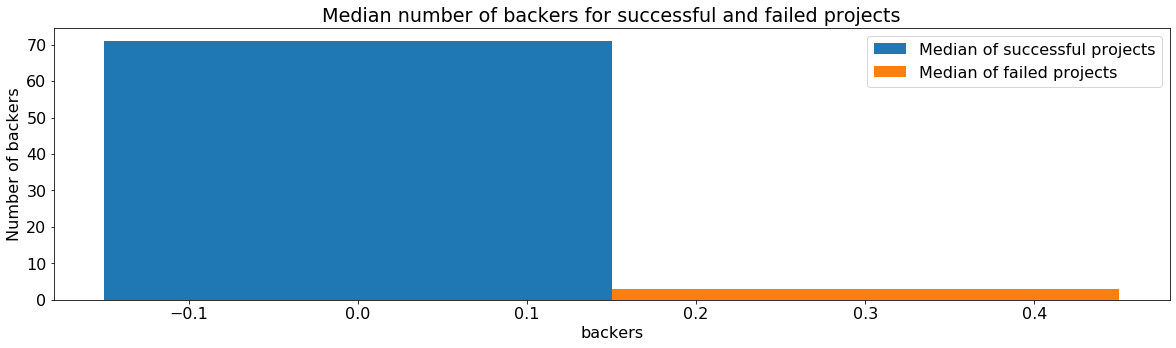

In [14]:
#Plotting the median number of backers for success/fail projects side by side
len = np.arange(1)
plt.figure(figsize=(20,5))
width = 0.3
_ = plt.bar(len, np.median(ks_success['backers']), width, label='Median of successful projects')
_ = plt.bar(len + width, np.median(ks_fail['backers']), width, label='Median of failed projects')
_ = plt.title('Median number of backers for successful and failed projects')
_ = plt.ylabel('Number of backers')
_ = plt.xlabel('backers')
_ = plt.legend(loc='best')

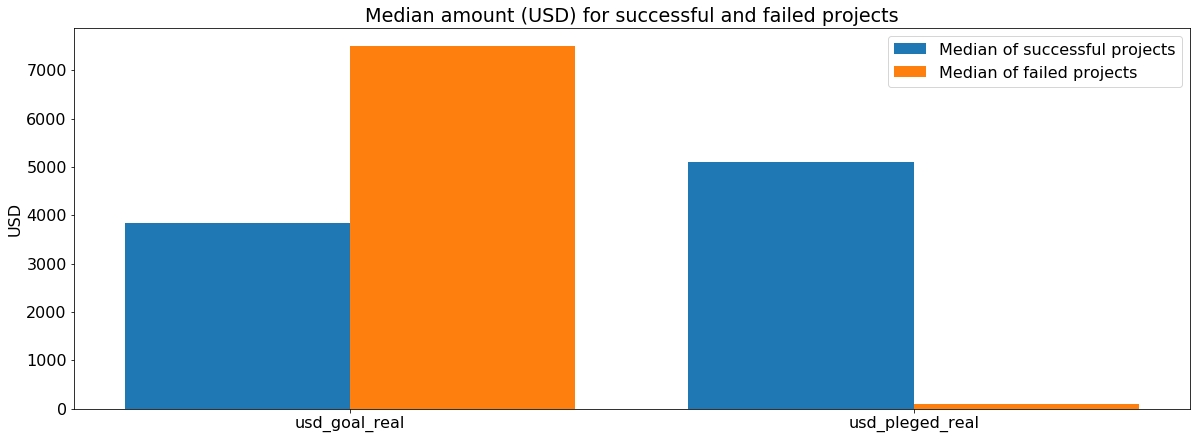

In [15]:
#Plotting the median goal/pledge for success/fail projects side by side
median_success = [np.median(ks_success['usd_goal_real']), np.median(ks_success['usd_pledged_real'])]
median_fail = [np.median(ks_fail['usd_goal_real']), np.median(ks_fail['usd_pledged_real'])]
len = np.arange(2)
plt.figure(figsize=(20,7))
width = 0.4
_ = plt.bar(len, median_success, width, label='Median of successful projects')
_ = plt.bar(len + width, median_fail, width, label='Median of failed projects')
_ = plt.title('Median amount (USD) for successful and failed projects')
_ = plt.ylabel('USD')
_ = plt.xticks(len + width / 2, ('usd_goal_real', 'usd_pleged_real'))
_ = plt.legend(loc='best')

## Looking at sucessful/failed projects over 2009-2017, we see that successful projects don't change much over the years, while failed project fluctuate more. 
With a boom of new projects in 2014/2015, the successful project numbers changed minimally. The increase in projects does not improve the amount of successful projects, as the boom of project numbers may make more competition for funding. With the number of projects trending down, creating a new project with these lower project amounts may have a better chance for success when compared with the other projects.   

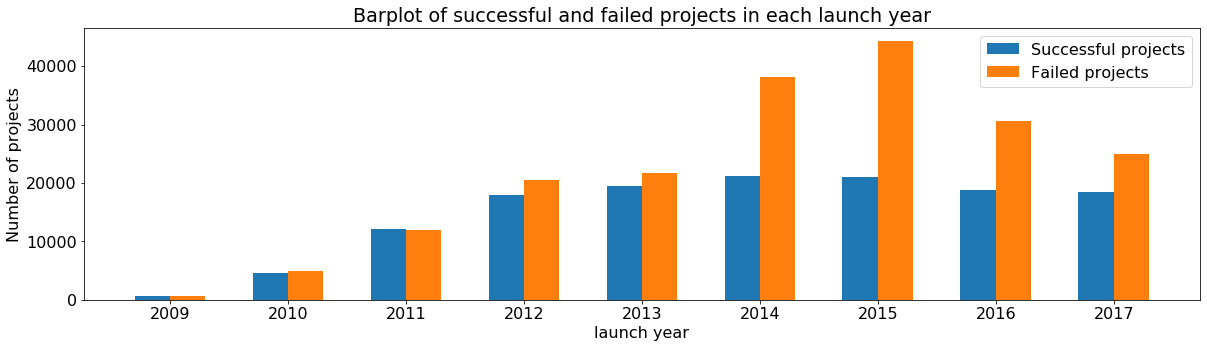

In [16]:
#Setting up the figure and width between the bars
len = np.arange(9)
plt.figure(figsize=(20,5))
width = 0.3

#Finding the counts of each launch year in the two datasets
counts_success = ks_success['launch_year'].value_counts().sort_index()
counts_fail = ks_fail['launch_year'].value_counts().sort_index()

#Plotting the success/fail counts over the years side by side
_ = plt.bar(len, counts_success, width, label='Successful projects')
_ = plt.bar(len + width, counts_fail, width, label='Failed projects')
_ = plt.xlabel('launch year')
_ = plt.xticks(len + width / 2, range(2009,2018))
_ = plt.ylabel('Number of projects')
_ = plt.title('Barplot of successful and failed projects in each launch year')
_ = plt.legend(loc='best')

## How do the goals look for successful and failed projects?
Seeing the distributions of successful and failed goals of projects, we see more projects with lower goals among successful projects, and more projects with higher goals for failed projects. Possibly a correlation between having a lower project goal and being successful? We'll explore that later.

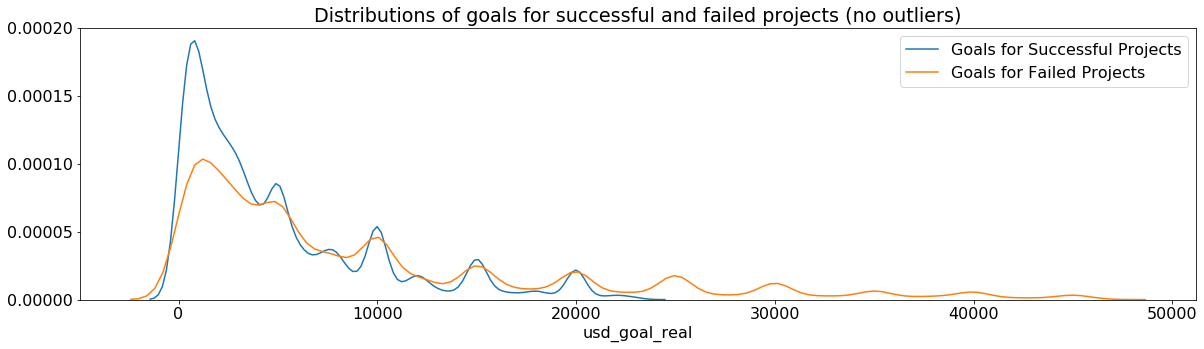

In [17]:
#Removing the outliers from the goals of successful projects
success_goal = ks_success['usd_goal_real']
success_goal_no_outliers = remove_outliers(success_goal)

#Removing the outliers from the goals of failed projects
fail_goal = ks_fail['usd_goal_real']
fail_goal_no_outliers = remove_outliers(fail_goal)

#Plotting the distributions of the successful and failed goals of projects
_ = sns.distplot(success_goal_no_outliers, hist=False, label='Goals for Successful Projects')
_ = sns.distplot(fail_goal_no_outliers, hist=False, label='Goals for Failed Projects')
_ = plt.title('Distributions of goals for successful and failed projects (no outliers)')

## Which main categories do the best in terms of successful projects? How does this compare to their number of failed projects?
While Film & Video has many successful projects, it is also has the most failed projects. With this measure, maybe looking at success percentage in the categories would be better to view successful categories. 

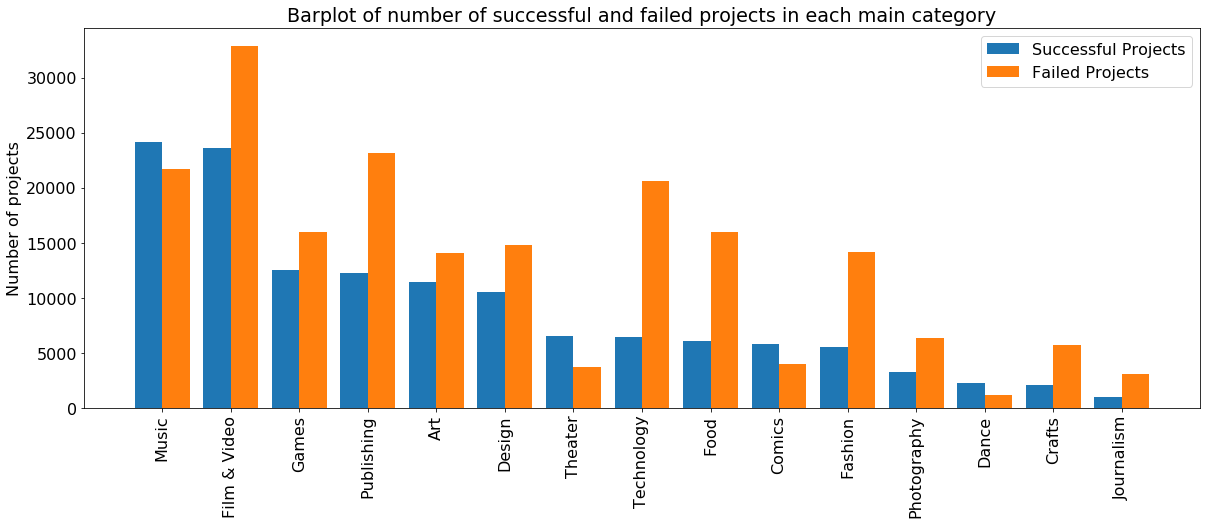

In [18]:
#Plotting the successful projects in each main category
success_counts = ks_success['main_category'].value_counts()
fail_counts = ks_fail['main_category'].value_counts()
len = np.arange(15)
plt.figure(figsize=(20,7))
width = 0.4
_ = plt.bar(len, success_counts, width, label='Successful Projects')
_ = plt.bar(len + width, fail_counts[success_counts.index], width, label='Failed Projects')
_ = plt.title('Barplot of number of successful and failed projects in each main category')
_ = plt.ylabel('Number of projects')
_ = plt.xticks(len + width / 2, success_counts.index[:20], rotation=90)
_ = plt.legend(loc='best')

Looking at the top 20 categories for successful projects and the corresponding fail amounts, we see a couple of categories that perform well, including Tabletop Games, Shorts, Theater, and more.

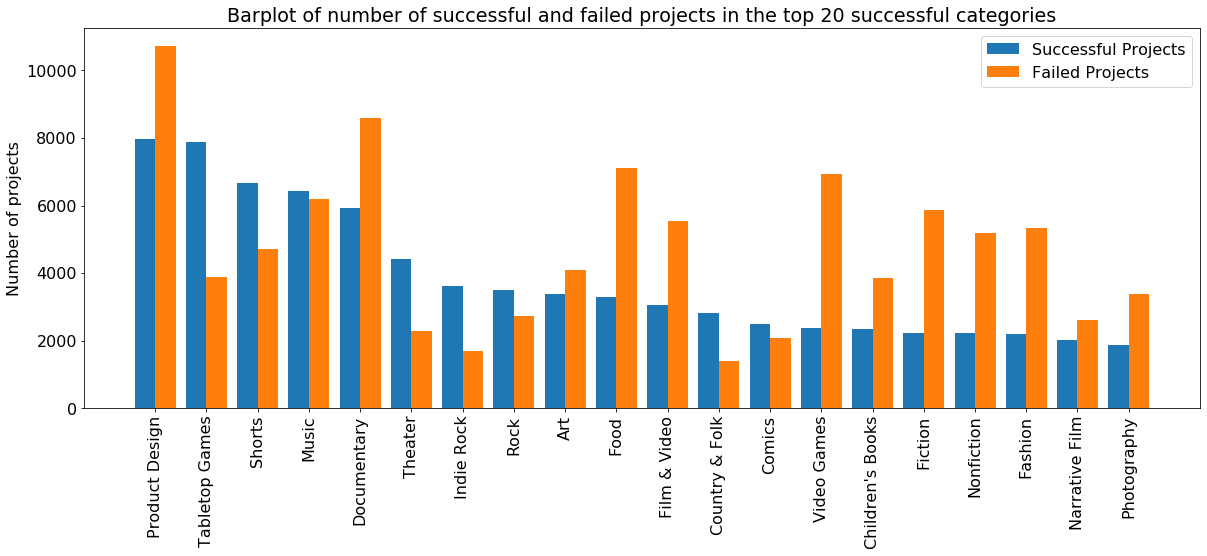

In [19]:
#Plotting the top 20 successful categories by number of projects
success_counts = ks_success['category'].value_counts()
fail_counts = ks_fail['category'].value_counts()
len = np.arange(20)
plt.figure(figsize=(20,7))
width = 0.4
_ = plt.bar(len, success_counts[:20], width, label='Successful Projects')
_ = plt.bar(len + width, fail_counts[success_counts.index[:20]], width, label='Failed Projects')
_ = plt.title('Barplot of number of successful and failed projects in the top 20 successful categories')
_ = plt.ylabel('Number of projects')
_ = plt.xticks(len + width / 2, success_counts.index[:20], rotation=90)
_ = plt.legend(loc='best')

In [20]:
#Creating a function to apply labels onto a bar plot
def bar_labels(ax, x, y):  
    totals = []
    for i in ax.patches:
        totals.append(i.get_height())
        
    total = sum(totals)
    for i in ax.patches:
        if i.get_height() > 0:
            ax.text(i.get_x() + x, i.get_height() + y, str(i.get_height()), color='black')
        else:
            ax.text(i.get_x() + x, i.get_height() - 3*y, str(i.get_height()), color='black')

In [21]:
#Creating a function to calculate percent
def percent_calc(num, denom):
    return num / denom * 100

## Since high successful project numbers can be coupled with high failed project numbers, looking at success percent in each main category would be better to determine top and bottom performing main categories.
We see the top success rates in Dance, Theater, and Comics, and the bottom success rates in Technology, Journalism, and Crafts. Kickstarter seems to support higher success rates for creative arts and not as conducive for tech and other categories.

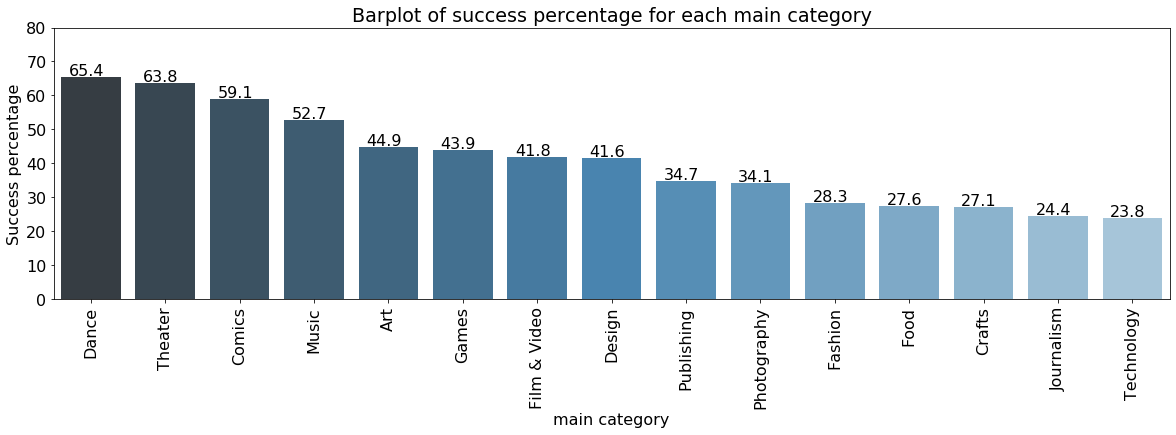

In [22]:
#Finding the success percent in each main category, sorting the values from highest to lowest
main_success_counts = ks_success['main_category'].value_counts()
main_success_percent = percent_calc(main_success_counts, ks['main_category'].value_counts())
main_success_percent = main_success_percent.sort_values(ascending=False).round(1)

#Plotting the success percent for each main category
ax = sns.barplot(main_success_percent.index, main_success_percent, palette='Blues_d')
_ = ax.set_alpha(1)
_ = ax.set_title('Barplot of success percentage for each main category')
_ = ax.set_xlabel('main category')
_ = plt.xticks(rotation=90)
_ = ax.set_yticks(range(0,90,10))
_ = ax.set_ylabel('Success percentage')

bar_labels(ax, 0.1, 0.5)

## Which categories have the best success rates?
Taking a look at some of the top and bottom categories, we can see even if the main categories aren't as successful, there are many sub categories that have a high success rate. Among the top successful percentage categories we see numerous that are from the Music main category. 

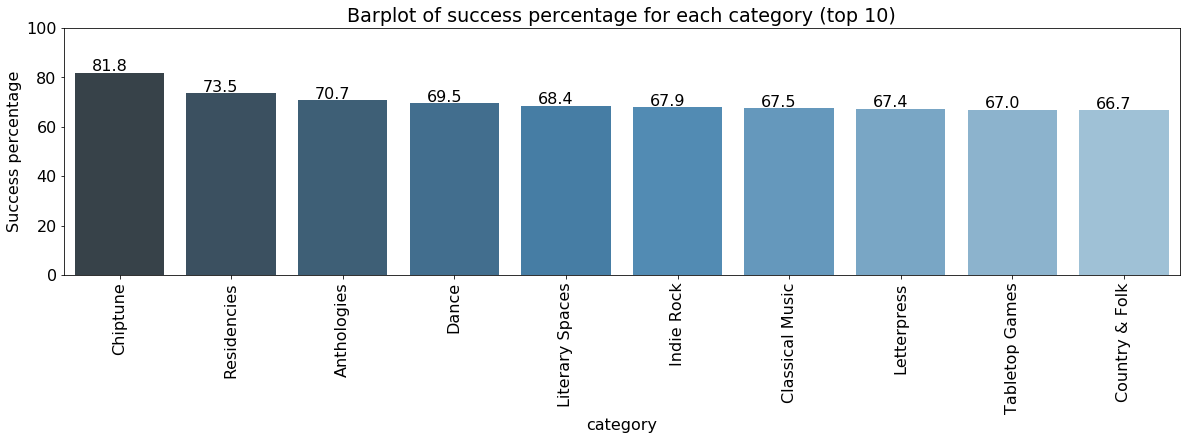

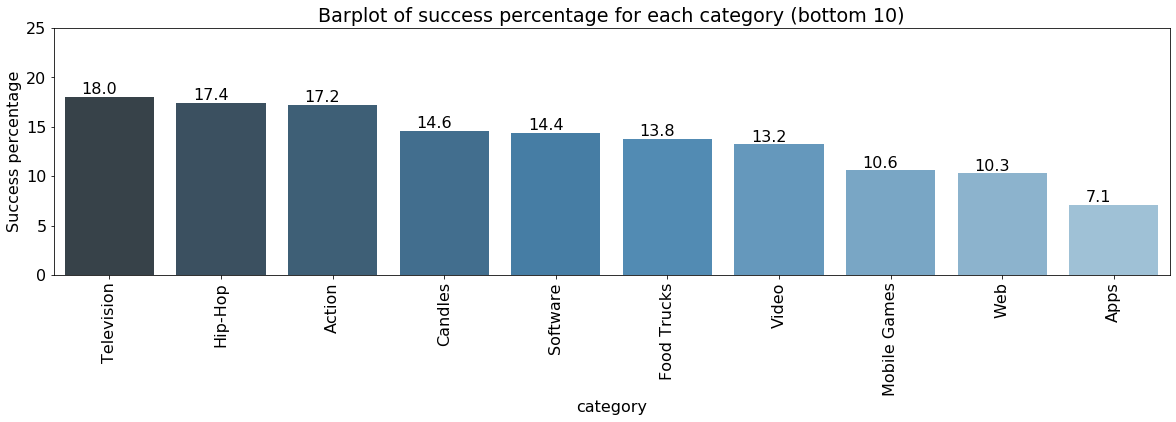

In [23]:
#Finding the success percent in each category, sorting the values from highest to lowest
category_success_counts = ks_success['category'].value_counts()
category_success_percent = percent_calc(category_success_counts, ks['category'].value_counts())
category_success_percent = category_success_percent.sort_values(ascending=False).round(1)

#Plotting the top 20 success percent categories
plt.figure(figsize =(20,10))
plt.subplot(2,1,1)
ax = sns.barplot(category_success_percent[:10].index, category_success_percent[:10], palette='Blues_d')
_ = ax.set_xlabel('category')
_ = plt.xticks(rotation=90)
_ = ax.set_yticks(range(0,120,20))
_ = ax.set_ylabel('Success percentage')
_ = ax.set_title('Barplot of success percentage for each category (top 10)')

bar_labels(ax, 0.15, 0.8)

#Plotting the bottom 20 success percent categories
plt.figure(figsize =(20,10))
plt.subplot(2,1,2)
ax = sns.barplot(category_success_percent[-10:].index, category_success_percent[-10:], palette='Blues_d')
_ = ax.set_xlabel('category')
_ = plt.xticks(rotation=90)
_ = ax.set_yticks(range(0,30,5))
_ = ax.set_ylabel('Success percentage')
_ = ax.set_title('Barplot of success percentage for each category (bottom 10)')

bar_labels(ax, 0.15, 0.3)

## How much do successful projects overshoot their goal? 

We see the mean is pretty far from the median here, 13137.94 versus 545.85, so there's some projects that overshoot their goal by a large amount.

In [24]:
#Finding the amounts that the pledge exceeds the goals by in the successful projects
success_pvg = ks_success['usd_pledged_real'] - ks_success['usd_goal_real']
success_pvg.describe()

count    1.339560e+05
mean     1.313794e+04
std      1.397532e+05
min     -5.284000e+03
25%      1.360950e+02
50%      5.458450e+02
75%      2.336000e+03
max      1.983899e+07
dtype: float64

We see a negative minimum value for the difference, so there was a project that succeeded but didn't reach its goal. Taking a look if there are other ones that did the same, we see 5 projects that didn't reach the goal. However, 3 out of 5 of them missed it by less that 40 cents. The others seem to have claimed success since they were close to their goal and received the majority of their funding. Also, they have a longer than normal duration, so they may have extended the duration to try and reach their goal.

In [25]:
#Showing which successful projects undershoot their goal
ks_success[ks_success['usd_pledged_real'] < ks_success['usd_goal_real']]

,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,duration(days),launch_year
72483,Santa's Sled,Art,Art,USD,2012-08-27,2012-07-26,successful,64,US,3599.69,3600.00,32,2012
151490,Borders of the Imagination - An Epic Sci-Fi/Fa...,Shorts,Film & Video,USD,2015-12-27,2015-11-12,successful,275,US,30716.00,36000.00,45,2015
232422,Documentary film about Les Blank.,Documentary,Film & Video,USD,2010-07-18,2010-06-02,successful,73,US,7999.65,8000.00,46,2010
275777,Insiders/Out: Exploring Outsider Art in America,Art,Art,USD,2010-07-08,2010-05-27,successful,30,US,1999.66,2000.00,42,2010
335859,TUW Ruhla Watches - Comeback of a Legend,Product Design,Design,EUR,2016-03-19,2016-02-08,successful,90,DE,27765.07,27884.98,40,2016


With successful projects overshooting their goal by 14% on average, it seems the majority of projects either barely reach their goal or potentially end their project soon after they reach their goal. 

In [26]:
#Finding the median of the difference between goal and pledged
success_goal_median = ks_success['usd_goal_real'].median()
success_pvg_median = round(success_pvg.median(),2)

percent_increase = round(success_pvg_median/success_goal_median*100,2)
print('With a median goal in successful projects of $' + str(success_goal_median) + \
      ' we see that the median difference between pledged and goal of successful projects is $' + str(success_pvg_median) + \
      ', which is ' + str(percent_increase) + '% over their target.')

With a median goal in successful projects of $3837.74 we see that the median difference between pledged and goal of successful projects is $545.84, which is 14.22% over their target.


## Median pledge amounts seem to follow success percentage for the main categories.
Also having high success rates, we see Dance, Comics, and Theater have higher medians as well.

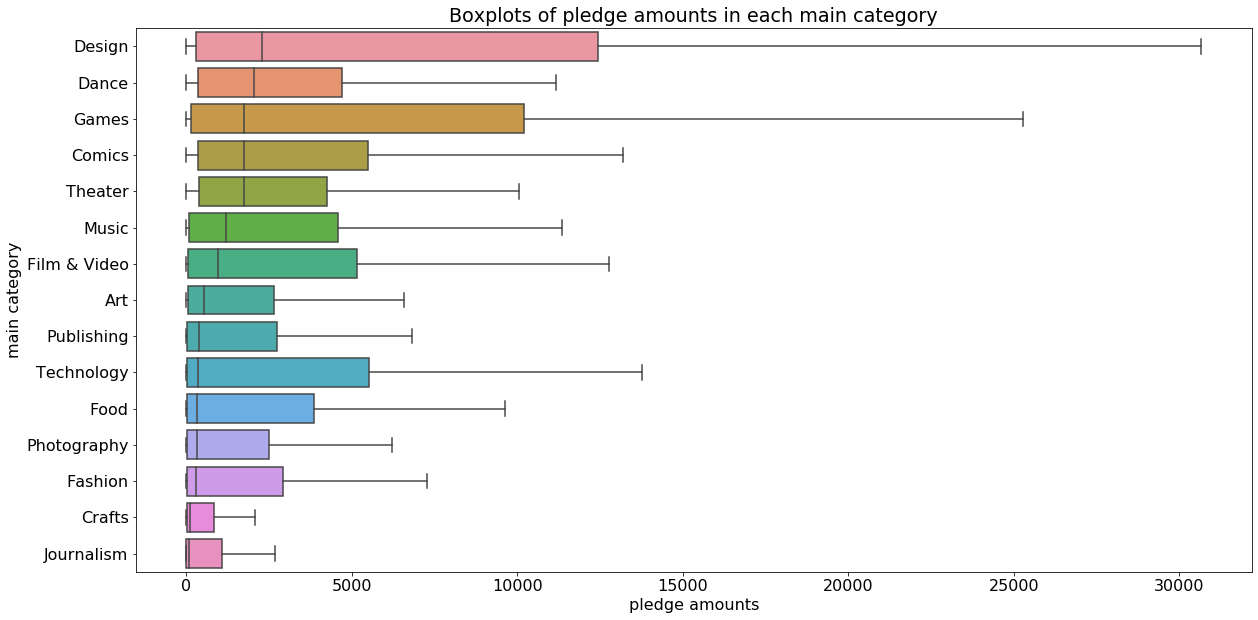

In [27]:
#Plotting average pledge amount per backer in each main category
pledged_index = ks.groupby(['main_category']).median().sort_values(['usd_pledged_real'], ascending=False).index

plt.figure(figsize=(20,10))
ax = sns.boxplot(x='usd_pledged_real', y='main_category', data=ks, showfliers=False, order=pledged_index)
_ = ax.set_ylabel('main category')
_ = ax.set_xlabel('pledge amounts')
_ = ax.set_title('Boxplots of pledge amounts in each main category')


## Technology, Design, and Food tend to have higher goal amounts, if they could manage to lower their goals they may have better chances of succeeding. 
Higher goal amounts may turn off people from pledging to a project as the chances of reaching a large number would be less. Goal amounts may not be able to be changed since that is the funding amount they would need for the project, unless they find ways to cut costs.

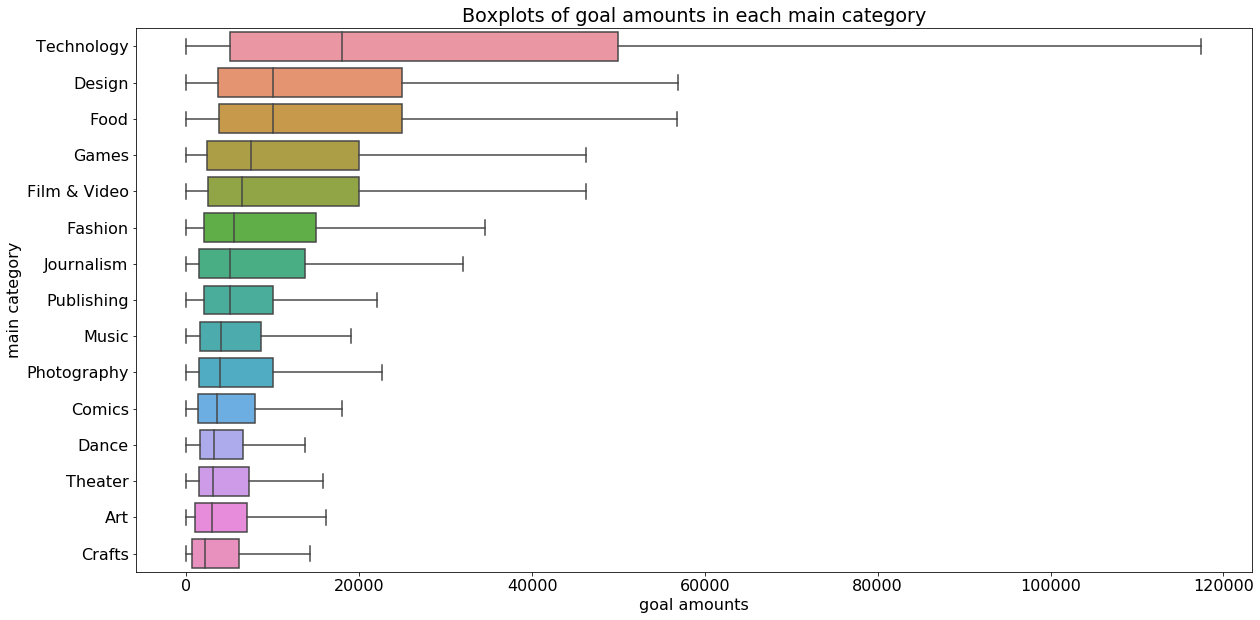

In [28]:
goal_index = ks.groupby(['main_category']).median().sort_values(['usd_goal_real'], ascending=False).index

plt.figure(figsize=(20,10))
ax = sns.boxplot(x='usd_goal_real', y='main_category', data=ks, showfliers=False, order=goal_index)
_ = ax.set_ylabel('main category')
_ = ax.set_xlabel('goal amounts')
_ = ax.set_title('Boxplots of goal amounts in each main category')

## Are there more backers pledging larger sums of money for a product, or is the amount of backers increasing relate to the amount pledged increase? 
It looks like there is a relationship between backers and pledged, we'll look further to see if there is a correlation between them.

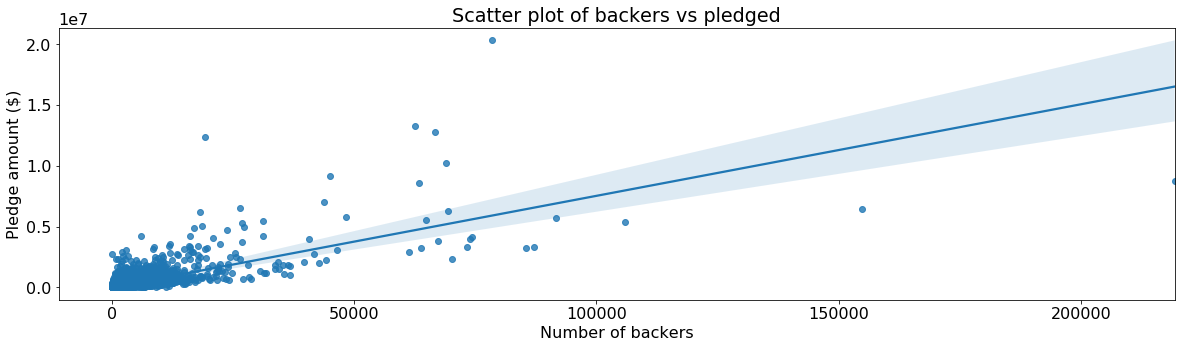

In [29]:
#Plotting the relationship between backers and amount pledged.
_ = sns.regplot(ks['backers'], ks['usd_pledged_real'], data=ks)
_ = plt.xlabel('Number of backers')
_ = plt.ylabel('Pledge amount ($)')
_ = plt.title('Scatter plot of backers vs pledged')

Next let's look at the columns and see how they correlate to the success state. Since there's way too many categories, we're only going to look at the correlation between the main categories and success state, as well as the numerical columns.

In [30]:
#Creating the dataframe for correlation and linear model.
temp = ks.drop(['name', 'category', 'currency', 'deadline', 'launched', 'country'],1)

#Encoding the success state and each of the main categories for the correlation calculation.
encode = pd.get_dummies(temp, prefix=['state'], columns=['state'])
encode = encode.drop(['state_failed'],1)
encode = encode[['state_successful','main_category','backers','usd_pledged_real','usd_goal_real',
                 'duration(days)','launch_year']]
encode = pd.get_dummies(encode, prefix=['main'], columns=['main_category'])
encode.head()

,state_successful,backers,usd_pledged_real,usd_goal_real,duration(days),launch_year,main_Art,main_Comics,main_Crafts,main_Dance,...,main_Fashion,main_Film & Video,main_Food,main_Games,main_Journalism,main_Music,main_Photography,main_Publishing,main_Technology,main_Theater
0,0,0,0.0,1533.95,59,2015,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,15,2421.0,30000.00,60,2017,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,3,220.0,45000.00,45,2013,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,1,1.0,5000.00,30,2012,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,1,224,52375.0,50000.00,35,2016,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


## After encoding the state and main category columns and looking at the correlation matrix, we see that the number of backers is strongly correlated with the amount pledged to a project, which isn't surprising. 
There are some positive and negative correlations in relation to state_success, although it is a weaker correlation.

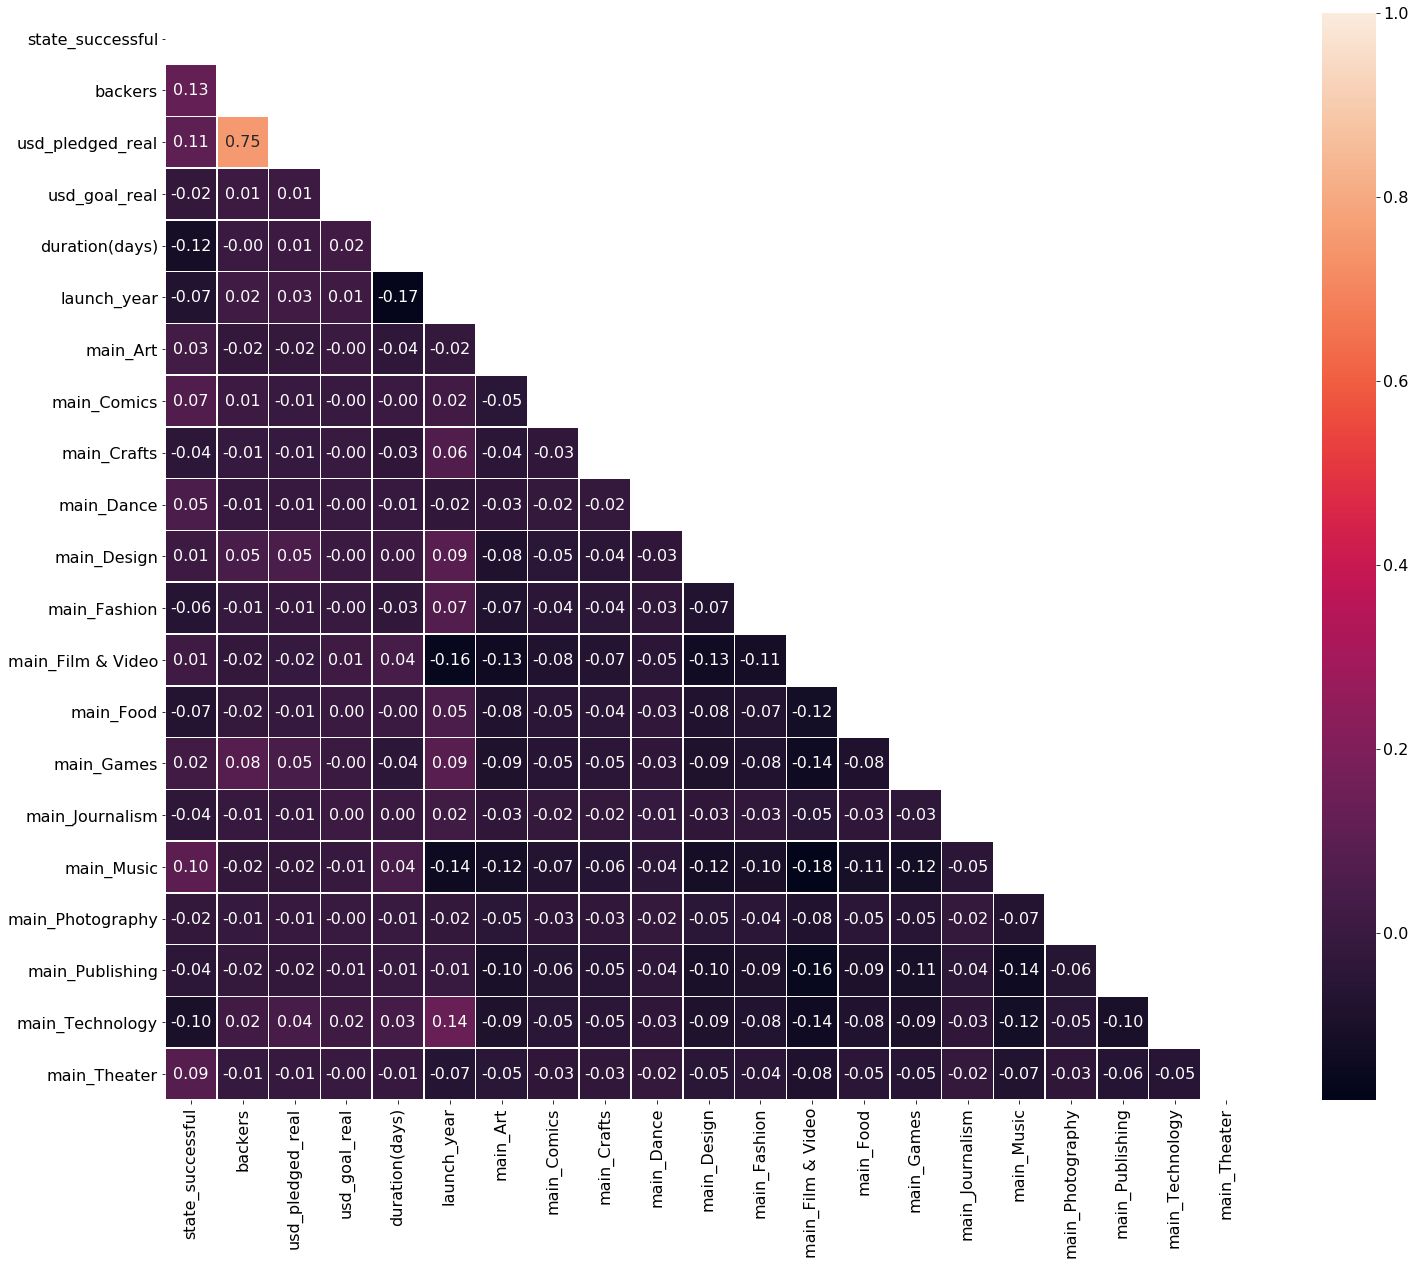

In [31]:
#Setting formatting for heatmap and plotting the correlations as a heatmap
fig, ax = plt.subplots(figsize=(25,20))
matrix = np.triu(encode.corr())
_ = sns.heatmap(encode.corr(), annot=True, fmt='.2f', square=True, mask=matrix, linewidths=0.5, ax=ax)

Notably, the number of backers and amount pledged correlates with being successful, which isn't surprising. We see a number of categories that correlate with success (although being weak correlation), including Music and Theater. Also, there are some that have a negative correlation with success as well including Technology and Food. We see that launch year and duration have a negative correlation with success.

Obviously wanting to get more backers and pledge amounts to get your project to succeed, so creating better incentives for backers could lead to more backers/pledges. With duration having a negative correlation with success, extending the duration tends to lower success chances. For the best chances of success, a quicker funding duration should be implemented.

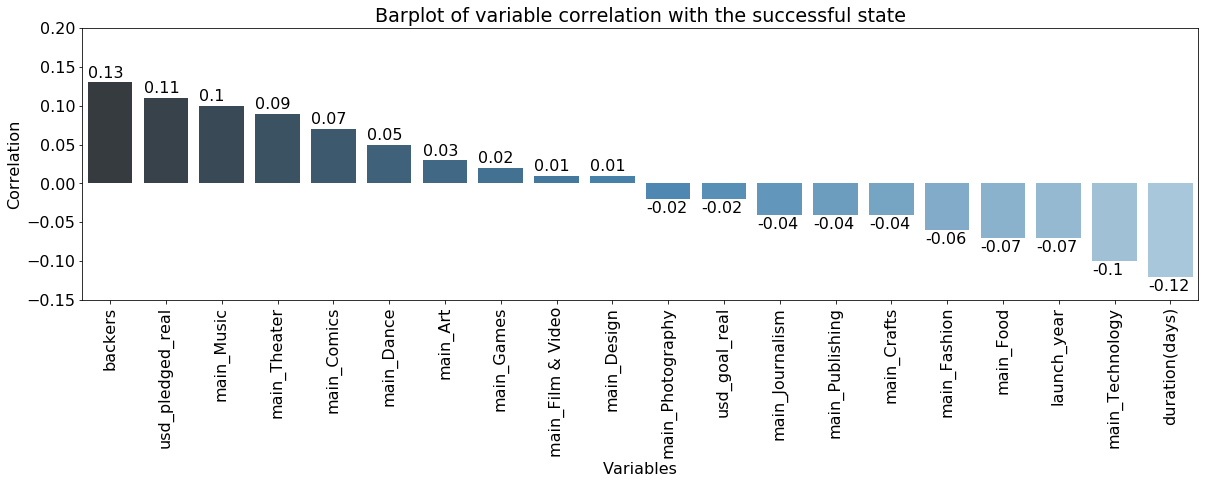

In [32]:
#Plotting the correlations with state_successful.
correlation = encode.corr()['state_successful'].sort_values(ascending=False).round(2)
ax = sns.barplot(correlation[1:].index, correlation[1:], palette='Blues_d')
_ = ax.set_xlabel('Variables')
_ = plt.xticks(rotation=90)
_ = ax.set_yticks(np.arange(-0.15,0.25,0.05))
_ = ax.set_ylabel('Correlation')
_ = ax.set_title('Barplot of variable correlation with the successful state')

bar_labels(ax, 0, 0.006)

In [33]:
#Setting up filter and target variable for the regression
dependentVar = encode['state_successful']
filt = encode.columns.drop('state_successful')

#Creating variables with a constant for regression
X = encode[filt]
X = sm.add_constant(X)

#Creating the model and showing the summary of the regression
model = sm.OLS(dependentVar, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       state_successful   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     1539.
Date:                Mon, 27 Jul 2020   Prob (F-statistic):               0.00
Time:                        15:11:47   Log-Likelihood:            -2.2047e+05
No. Observations:              331675   AIC:                         4.410e+05
Df Residuals:                  331655   BIC:                         4.412e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                29.2119      0.85

In [34]:
#Using a scaler to scale that data for a second model.
encode_scaled = encode
scale_filt = ['backers','usd_pledged_real','usd_goal_real','duration(days)','launch_year']
min_max_scaler = preprocessing.MinMaxScaler()
encode_scaled[scale_filt] = min_max_scaler.fit_transform(encode_scaled[scale_filt])

dependentVar = encode_scaled['state_successful']
filt = encode_scaled.columns.drop('state_successful')

#Creating variables with a constant for regression
X = encode_scaled[filt]
X = sm.add_constant(X)

#Creating the model and showing the summary of the regression
model = sm.OLS(dependentVar, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       state_successful   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     1539.
Date:                Mon, 27 Jul 2020   Prob (F-statistic):               0.00
Time:                        15:11:48   Log-Likelihood:            -2.2047e+05
No. Observations:              331675   AIC:                         4.410e+05
Df Residuals:                  331655   BIC:                         4.412e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.6036      0.00

# Insight

## Since high successful project numbers can be coupled with high failed project numbers, looking at success percent in each main category would be better to determine top and bottom performing main categories.
We see the top success rates in Dance, Theater, and Comics, and the bottom success rates in Technology, Journalism, and Crafts. Kickstarter seems to support higher success rates for creative arts and not as conducive for tech and other categories.

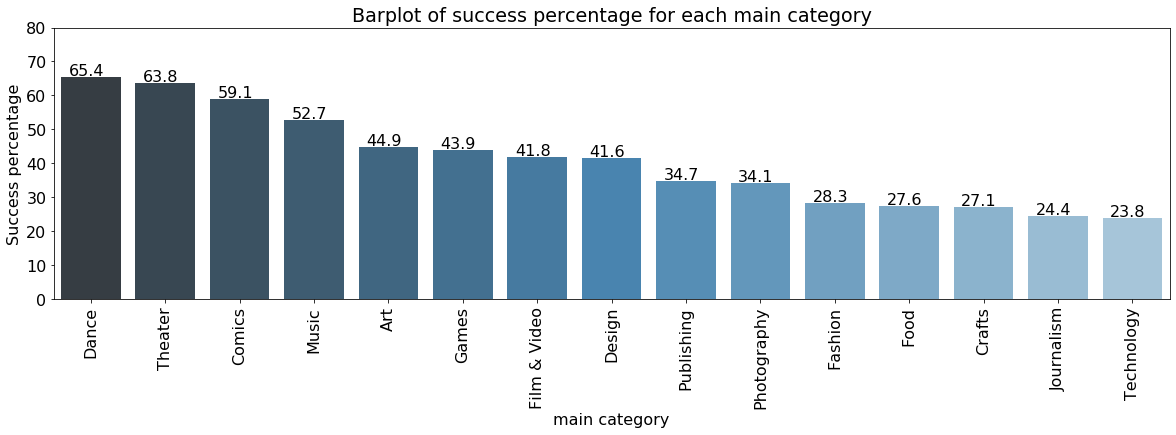

In [35]:
#Finding the success percent in each main category, sorting the values from highest to lowest
main_success_counts = ks_success['main_category'].value_counts()
main_success_percent = percent_calc(main_success_counts, ks['main_category'].value_counts())
main_success_percent = main_success_percent.sort_values(ascending=False).round(1)

#Plotting the success percent for each main category
ax = sns.barplot(main_success_percent.index, main_success_percent, palette='Blues_d')
_ = ax.set_alpha(1)
_ = ax.set_title('Barplot of success percentage for each main category')
_ = ax.set_xlabel('main category')
_ = plt.xticks(rotation=90)
_ = ax.set_yticks(range(0,90,10))
_ = ax.set_ylabel('Success percentage')

bar_labels(ax, 0.1, 0.5)

## Which categories have the best success rates?
Taking a look at some of the top and bottom categories, we can see even if the main categories aren't as successful, there are many sub categories that have a high success rate. Among the top successful percentage categories we see numerous that are from the Music main category, and numerous of the lower performing categories are from the technology main category. When looking at a project's category we can get a decent idea of how likely it would be to succeed.

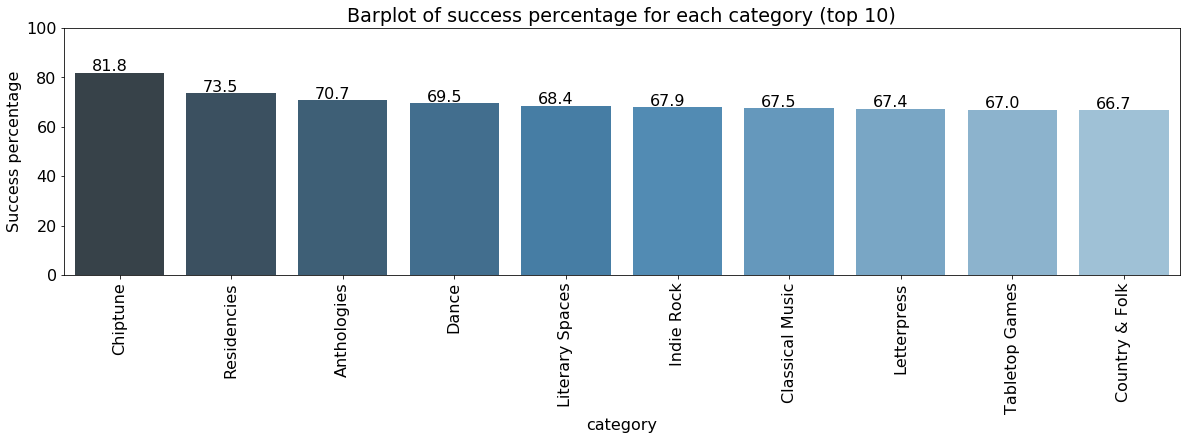

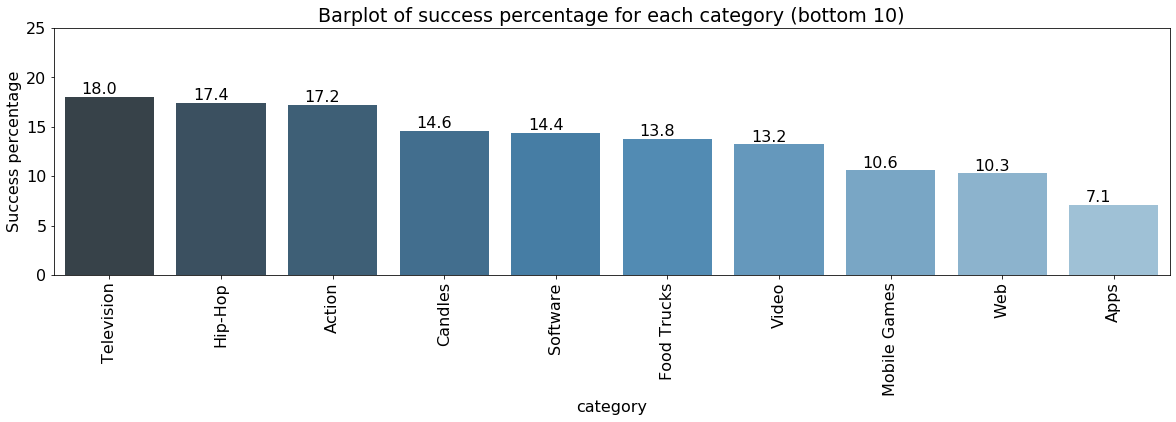

In [36]:
#Finding the success percent in each category, sorting the values from highest to lowest
category_success_counts = ks_success['category'].value_counts()
category_success_percent = percent_calc(category_success_counts, ks['category'].value_counts())
category_success_percent = category_success_percent.sort_values(ascending=False).round(1)

#Plotting the top 20 success percent categories
plt.figure(figsize =(20,10))
plt.subplot(2,1,1)
ax = sns.barplot(category_success_percent[:10].index, category_success_percent[:10], palette='Blues_d')
_ = ax.set_xlabel('category')
_ = plt.xticks(rotation=90)
_ = ax.set_yticks(range(0,120,20))
_ = ax.set_ylabel('Success percentage')
_ = ax.set_title('Barplot of success percentage for each category (top 10)')

bar_labels(ax, 0.15, 0.8)

#Plotting the bottom 20 success percent categories
plt.figure(figsize =(20,10))
plt.subplot(2,1,2)
ax = sns.barplot(category_success_percent[-10:].index, category_success_percent[-10:], palette='Blues_d')
_ = ax.set_xlabel('category')
_ = plt.xticks(rotation=90)
_ = ax.set_yticks(range(0,30,5))
_ = ax.set_ylabel('Success percentage')
_ = ax.set_title('Barplot of success percentage for each category (bottom 10)')

bar_labels(ax, 0.15, 0.3)

Notably, the number of backers and amount pledged correlates with being successful, which isn't surprising. We see a number of categories that correlate with success (although being weak correlation), including Music and Theater. Also, there are some that have a negative correlation with success as well including Technology and Food. We see that launch year and duration have a negative correlation with success.

Obviously wanting to get more backers and pledge amounts to get your project to succeed, so creating better incentives for backers could lead to more backers/pledges. With duration having a negative correlation with success, extending the duration tends to lower success chances. For the best chances of success, a quicker funding duration should be implemented. If a project doesn't gain traction quickly and funding may not be reached, it may just be beneficial to cancel the project, as success would be less likely to be reached.

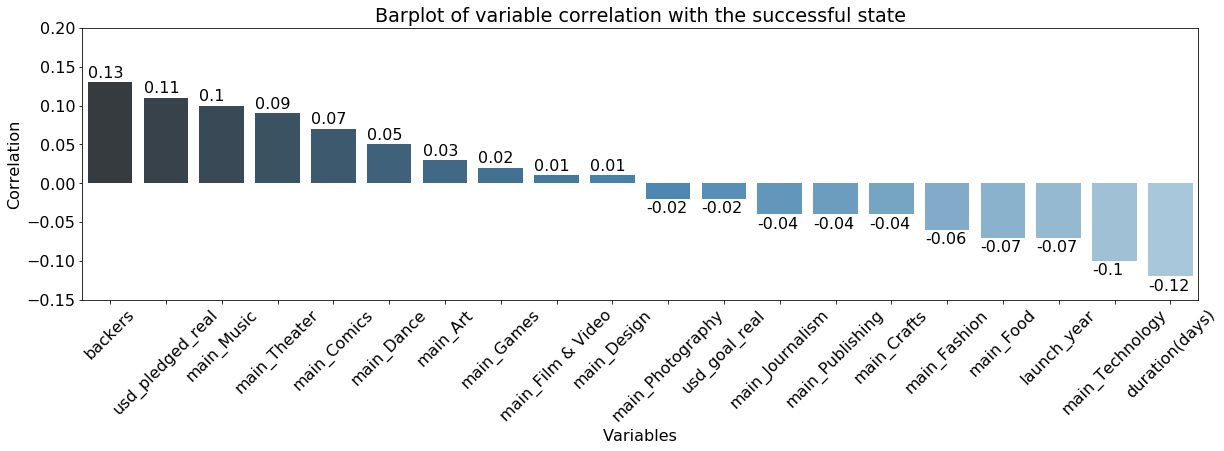

In [37]:
#Plotting the correlations with state_successful.
correlation = encode.corr()['state_successful'].sort_values(ascending=False).round(2)
ax = sns.barplot(correlation[1:].index, correlation[1:], palette='Blues_d')
_ = ax.set_xlabel('Variables')
_ = plt.xticks(rotation=45)
_ = ax.set_yticks(np.arange(-0.15,0.25,0.05))
_ = ax.set_ylabel('Correlation')
_ = ax.set_title('Barplot of variable correlation with the successful state')

bar_labels(ax, 0, 0.006)